In [1]:
#libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import wrangle #acquire, prep and clean library
import env
import explore

from scipy import stats
from scipy.stats import pearsonr, spearmanr

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split

from math import sqrt

# Notes

# Planning

# Data Acquisition

- Predict the values of single unit properties that the tax district assesses using the property data from those with a transaction during the "hot months" (in terms of real estate demand) of May-August, 2017.

In [2]:
df = wrangle.get_zillow_data()
df.head(2)

,parcelid,bathroomcnt,bedroomcnt,fips,garagecarcnt,lotsizesquarefeet,yearbuilt,taxvaluedollarcnt,calculatedfinishedsquarefeet,transaction_date
0,11721753,2.0,3.0,6037.0,NaN,5672.0,1923.0,205123.0,1316.0,2017-07-21
1,11289917,2.0,3.0,6037.0,NaN,8284.0,1970.0,136104.0,1458.0,2017-06-23


##### Acquired dataset
1. Queried single family homes from "hot months" May to August 2017 as stated in the project scenario.

# Data Preparation

In [3]:
df.shape

(28124, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28124 entries, 0 to 28123
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      28124 non-null  int64  
 1   bathroomcnt                   28124 non-null  float64
 2   bedroomcnt                    28124 non-null  float64
 3   fips                          28124 non-null  float64
 4   garagecarcnt                  9953 non-null   float64
 5   lotsizesquarefeet             27921 non-null  float64
 6   yearbuilt                     28053 non-null  float64
 7   taxvaluedollarcnt             28123 non-null  float64
 8   calculatedfinishedsquarefeet  28077 non-null  float64
 9   transaction_date              28124 non-null  object 
dtypes: float64(8), int64(1), object(1)
memory usage: 2.1+ MB


In [5]:
df.isnull().sum()

parcelid                            0
bathroomcnt                         0
bedroomcnt                          0
fips                                0
garagecarcnt                    18171
lotsizesquarefeet                 203
yearbuilt                          71
taxvaluedollarcnt                   1
calculatedfinishedsquarefeet       47
transaction_date                    0
dtype: int64

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
parcelid,28124.0,1.304239e+07,3.747700e+06,10711855.0,11513802.75,12596700.0,14149137.75,167687839.0
bathroomcnt,28124.0,2.316509e+00,1.016983e+00,0.0,2.00,2.0,3.00,11.0
bedroomcnt,28124.0,3.309487e+00,9.430731e-01,0.0,3.00,3.0,4.00,12.0
fips,28124.0,6.049521e+03,2.130214e+01,6037.0,6037.00,6037.0,6059.00,6111.0
garagecarcnt,9953.0,1.951271e+00,5.621865e-01,0.0,2.00,2.0,2.00,14.0
lotsizesquarefeet,27921.0,1.111366e+04,6.947169e+04,236.0,5592.00,6854.0,8802.00,6971010.0
yearbuilt,28053.0,1.963773e+03,2.310895e+01,1878.0,1950.00,1961.0,1979.00,2016.0
taxvaluedollarcnt,28123.0,5.350049e+05,7.076811e+05,1000.0,198636.00,382798.0,632767.00,23858374.0
calculatedfinishedsquarefeet,28077.0,1.934930e+03,9.956845e+02,240.0,1278.00,1675.0,2326.00,17245.0


In [7]:
df = df.drop_duplicates()
df.shape

(28124, 10)

In [8]:
df = df.rename(columns={"bedroomcnt": "bedrooms", "bathroomcnt": "bathrooms", "calculatedfinishedsquarefeet":"square_feet", "taxvaluedollarcnt":"tax_value", "yearbuilt":"year_built", "fips":"county_code", "garagecarcnt":"garage", "lotsizesquarefeet":"lot_size"})
df.head(0)

,parcelid,bathrooms,bedrooms,county_code,garage,lot_size,year_built,tax_value,square_feet,transaction_date


In [9]:
convert_dict = {'county_code': object, 'parcelid':object, 'lot_size':object}
df = df.astype(convert_dict)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28124 entries, 0 to 28123
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   parcelid          28124 non-null  object 
 1   bathrooms         28124 non-null  float64
 2   bedrooms          28124 non-null  float64
 3   county_code       28124 non-null  object 
 4   garage            9953 non-null   float64
 5   lot_size          27921 non-null  object 
 6   year_built        28053 non-null  float64
 7   tax_value         28123 non-null  float64
 8   square_feet       28077 non-null  float64
 9   transaction_date  28124 non-null  object 
dtypes: float64(6), object(4)
memory usage: 2.4+ MB


In [10]:
df.isnull().sum()

parcelid                0
bathrooms               0
bedrooms                0
county_code             0
garage              18171
lot_size              203
year_built             71
tax_value               1
square_feet            47
transaction_date        0
dtype: int64

In [11]:
#keep after query 18171 nulls
df['garage'] = df.garage.fillna(value = df['garage'].mean())

In [12]:
#keep after query 1 null
df['tax_value'] = df.tax_value.fillna(value = df['tax_value'].mean())

In [13]:
#keep after query 47 nulls
df['square_feet'] = df.square_feet.fillna(value = df['square_feet'].mean())

In [14]:
#keep after query 71 nulls
df['lot_size'] = df.lot_size.fillna(value = df['lot_size'].mean())

In [15]:
#keep after query 203 nulls
df['year_built'] = df.year_built.fillna(value = df['year_built'].mean())

In [16]:
#converts floats to int and obj
convert_dict_int = {'bathrooms': int, 'bedrooms': int, 'garage':int, 'tax_value':int,
                   'square_feet':int, 'lot_size':int, 'year_built': object}
df = df.astype(convert_dict_int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28124 entries, 0 to 28123
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   parcelid          28124 non-null  object
 1   bathrooms         28124 non-null  int64 
 2   bedrooms          28124 non-null  int64 
 3   county_code       28124 non-null  object
 4   garage            28124 non-null  int64 
 5   lot_size          28124 non-null  int64 
 6   year_built        28124 non-null  object
 7   tax_value         28124 non-null  int64 
 8   square_feet       28124 non-null  int64 
 9   transaction_date  28124 non-null  object
dtypes: int64(6), object(4)
memory usage: 2.4+ MB


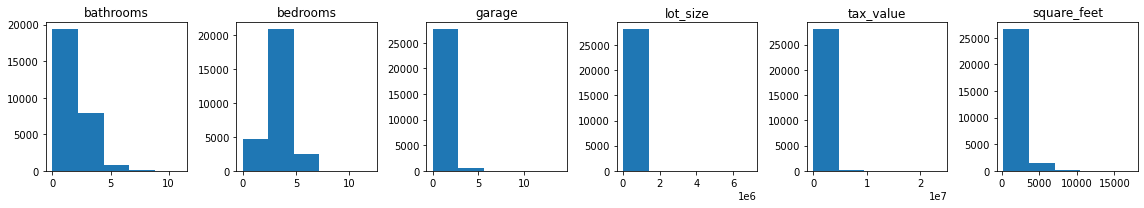

In [17]:
#prior to removing outliers
#had to add 'transaction_date' to the drop column within the function
wrangle.get_hist(df)

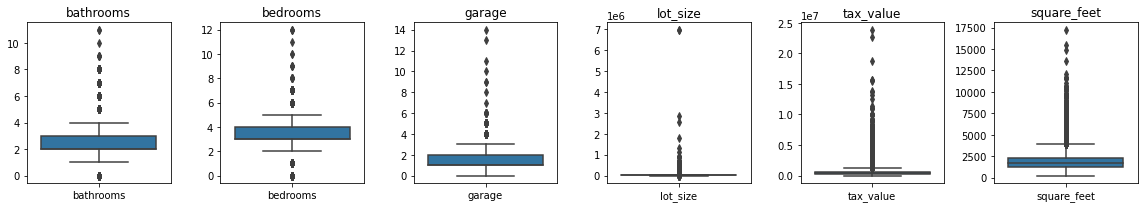

In [18]:
#prior to removing outliers
wrangle.get_box(df)

In [19]:
#remove outliers
k = 1.5
col_list = ['bathrooms', 'bedrooms', 'garage', 'lot_size', 'tax_value', 'square_feet']
df = wrangle.remove_outliers(df, k , col_list)
df.head()

,parcelid,bathrooms,bedrooms,county_code,garage,lot_size,year_built,tax_value,square_feet,transaction_date
0,11721753,2,3,6037.0,1,5672,1923.0,205123,1316,2017-07-21
1,11289917,2,3,6037.0,1,8284,1970.0,136104,1458,2017-06-23
2,11705026,1,2,6037.0,1,6707,1911.0,35606,1421,2017-06-30
3,14269464,3,4,6059.0,2,4975,2003.0,880456,2541,2017-06-01
4,11446756,2,3,6037.0,1,5000,1955.0,107110,1491,2017-08-23


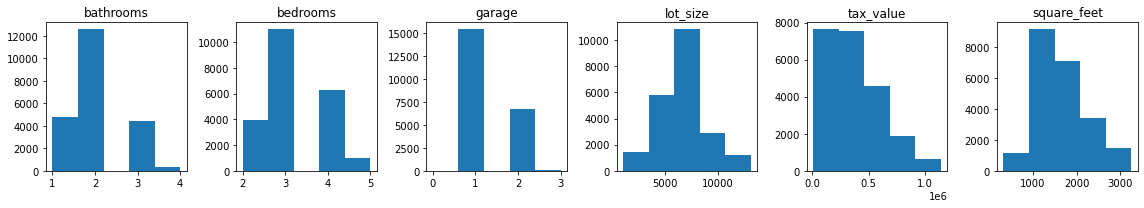

In [20]:
#after removing outliers
wrangle.get_hist(df)

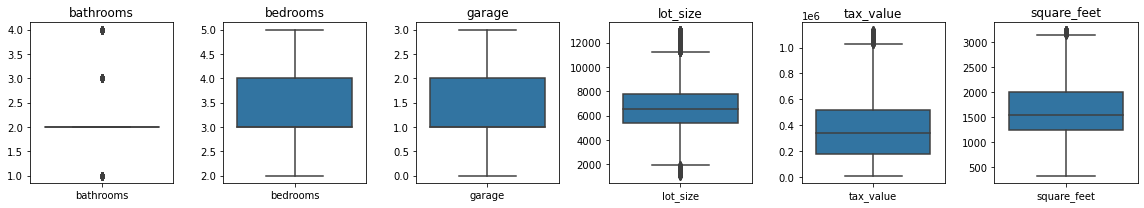

In [21]:
#after removing outliers
wrangle.get_box(df)

##### NOTES

1. SQL zillow dataset
2. property type - Single Family - 261
3. .shape (2152863, 61)
4. After initial data acquisition .shape (2152863, 16)
    - From initial acquisition I kept the following columns:
    - parcelid, basementsqft, bathroomcnt, bedroomcnt, fips, garagecarcnt, garagetotalsqft, lotsizesquarefeet, poolcnt, poolsizesum, roomcnt, unitcnt, yearbuilt, numberofstories, taxvaluedollarcnt, taxamount
5. Dropped (based on qty of nulls): basementsqft, garagetotalsqft, poolcnt, poolsizesum, unitcnt, numberofstories, roomcnt
6. Final .shape (2152985, 11)
7. Drop duplicates (2152982, 11) 
8. Fill in nulls (as identified in wrangle.py)
9. Drop columns
10. Visualize
11. Remove outliers
12. After prep'd data I queried "hot months" from sql
    - shape after query (28124, 12)
    - null counts show different numbers and prep function will need to be modified
    - no change in shape after dropping duplicates
    - modified prep function
    - modified outliersw
    
##### NOTES on Project Guidance
- The below, prior to data exploration, is built to project guidance.

## MVP

In [ ]:
# Use square_feet, bedrooms, bathrooms to estimate the property's assesed value 'tax_value'
# ADD new column "TAX_RATE" by using 'tax_value' multiplied by "ANNUAL_TAX"
# need to figure out which FIELDS make up "ANNUAL TAX"

# Data Exploration

1. What are the takeaways about the drivers of single unit property values?
2. Visualizations to support main points.

### Univariate

In [ ]:
explore.explore_univariate(train, cat_vars, quant_vars)

### Bivariate

In [ ]:
#exploring split
explore.explore_bivariate(train, target, cat_vars, quant_vars)

### Multivariate

In [ ]:
#exploring  split
explore.explore_multivariate(train, target, cat_vars, quant_vars)

# Hypothesis Testing

# Modeling